In [7]:
import dl_weather

# For generating the geocontext:
from IPython import display as dsp
import shapely.geometry as sg
import descarteslabs as dl
import geojson

# For plotting timeseries:
import matplotlib.pyplot as plt

import pickle
import pandas as pd

---
## Create geoctx

In [12]:
# Get shape of state in Brazil
places_client = dl.Places()
state = places_client.shape("north-america_united-states_california_sacramento-valley_yolo")

# Define Workflows GeoContext
geoctx = dl.scenes.AOI(sg.shape(state.geometry).simplify(0.01),
                       crs="EPSG:4326", resolution=0.01)

# Display on a map:
dsp.GeoJSON(geojson.Feature(geometry=geoctx.geometry))

<IPython.display.GeoJSON object>

---
---
## Run short unmasked timeseries:
1-month long, daily frequency

ERA5: precipitation and zonal wind speed

In [3]:
%%time
ts = dl_weather.get_weather_time_series(weather_product="ecmwf:era5:v0",
                                        weather_vars = ["tp"],
                                        weather_start = '2018-01-01',
                                        weather_end = '2018-02-01',
                                        frequency='daily',
                                        geoctx=geoctx)
ts.head()

Submitting 31 jobs 



  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 698 ms, sys: 138 ms, total: 836 ms
Wall time: 3min 7s


,tp
2018-01-01,0.006608
2018-01-02,0.015886
2018-01-03,0.005958
2018-01-04,0.000628
2018-01-05,0.005842


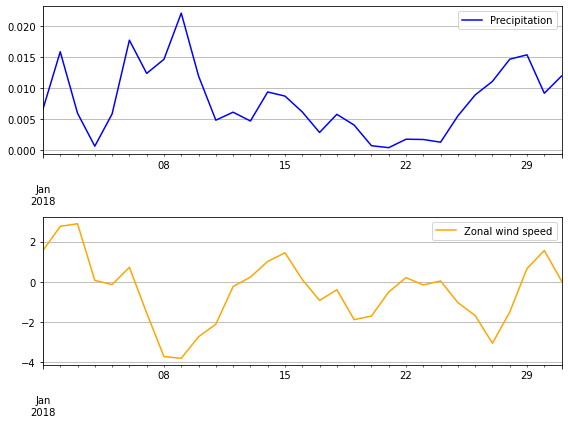

In [29]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
ts['tp'].plot(color='blue', label='Precipitation')
plt.grid('lightgray')
plt.legend()
plt.subplot(2,1,2) 
ts['100u'].plot(color='orange', label='Zonal wind speed')
plt.grid('lightgray')
plt.legend()
plt.tight_layout()


---
---
## Run masked timeseries
1-year long, monthly frequency

ERA5: precipitation and zonal wind speed

In [ ]:
%%time
ts = dl_weather.get_weather_time_series(weather_product="ecmwf:era5:v0",
                                        weather_vars = ["tp",'100u'],
                                        weather_start = '2015-01-01',
                                        weather_end = '2016-01-01',
                                        frequency='monthly',
                                        geoctx=geoctx,
                                        land_cover_product = "modis:mcd12q1:051",
                                        land_cover_bands = "Land_Cover_Type_1",
                                        land_cover_value = 12,
                                        land_cover_start = "2010-01-01",
                                        land_cover_end = "2011-01-01")
ts.head()

Submitting 12 jobs 



  0%|          | 0/12 [00:00<?, ?it/s]


Retrieving monthly timeseries


  0%|          | 0/12 [00:00<?, ?it/s]

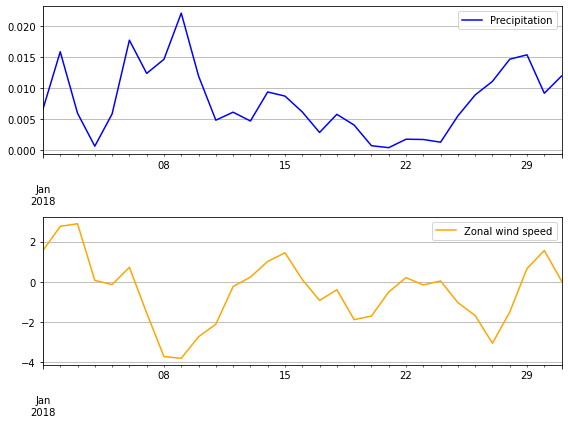

In [42]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
ts['tp'].plot(color='blue', label='Precipitation')
plt.grid('lightgray')
plt.legend()
plt.subplot(2,1,2)
ts['100u'].plot(color='orange', label='Zonal wind speed')
plt.grid('lightgray')
plt.legend()
plt.tight_layout()


---
---
## Run masked timeseries

10-year long, monthly frequency

ERA5: only precipitation


In [ ]:
%%time
ts = dl_weather.get_weather_time_series(weather_product="ecmwf:era5:v0",
                                        weather_vars = ["tp"],
                                        weather_start = '2005-01-01',
                                        weather_end = '2015-01-01',
                                        frequency='monthly',
                                        geoctx=geoctx,
                                        land_cover_product = "modis:mcd12q1:051",
                                        land_cover_bands = "Land_Cover_Type_1",
                                        land_cover_value = 12,
                                        land_cover_start = "2010-01-01",
                                        land_cover_end = "2011-01-01")
ts.head()

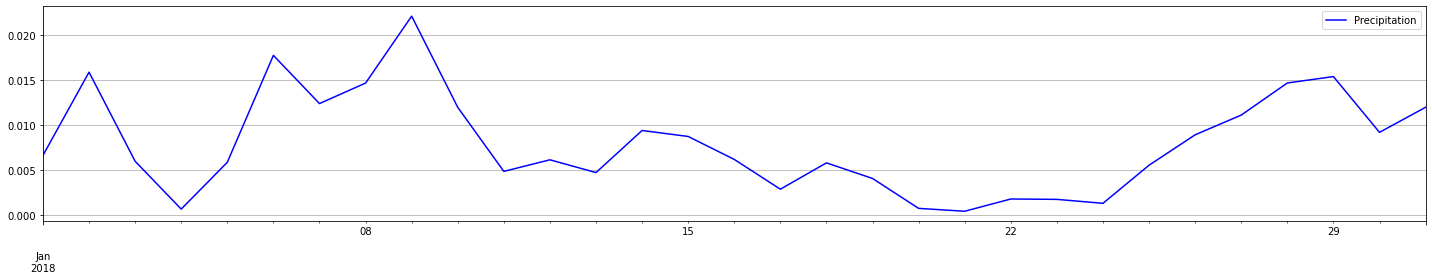

In [44]:
plt.figure(figsize=(20,4))
ts['tp'].plot(color='blue', label='Precipitation')
plt.grid('lightgray')
plt.legend()
plt.tight_layout()


# STANDARDIZED PRECIPITATION INDEX (SPI)
In this cell we are retrieving 30 years of data for calculating the index. If you don't have access to the `spi_input.pickle`, run this one. Otherwise move on to the next one. 
Note: this cell might take over two hours

In [ ]:
%%time
ts_spi= dl_weather.get_weather_time_series(weather_product="ecmwf:era5:v0",
                                        weather_vars = ["tp"],
                                        weather_start = '1990-01-01',
                                        weather_end = '2021-01-01',
                                        frequency='daily',
                                        geoctx=geoctx)
with open("spi_input.pickle", "wb") as f:
    pickle.dump((ts_spi), f)

### Calculating SPI
To calculate the SPI, a long-term precipitation record at the desired station is first fitted to a probability distribution (e.g. gamma distribution or pearson), which is then transformed into a normal distribution so that the mean SPI is zero.

`dl_weather.spi` will calculate the drought index for the given timeseries. SPI requires full years and you can fill the incomplete days with NaN. 

#### inputs to the function:

1: timeseries of the precipitation over the given AOI as numpy array.\
2: scaling= number of time steps over which the values should be scaled before the index is computed(e.g. 1 month,3 months, 12 months, 24 months). if the timeserie is daily, put the number of days for each time scale (3 months=90 days)\
3: distribution= `gamma` or `pearson`.\
4: the initial year of the input precipitation dataset.\
5: initial year of the calibration period in the historical period.\
6: final year of the calibration period. usually 10 years would be enough.\
7:number of years in the timeserie.\
8: periodicity= `daily` or `monthly` based on the timeserie.\
9: should be always `None`, since we are not giving precalculated distribution to the function.\

In [11]:
ts_spi=pd.read_pickle('spi_input.pickle')

test_spi=dl_weather.spi(ts_spi['tp'].values,
    90,
    "gamma",
    1990,
    1990,
    2000,
    31,
    "daily",
    None,
)

### Interepreting the SPI output

Positive SPI (Standard Precipitation Index) values indicate greater than mean precipitation and negative values indicate less than mean precipitation. The SPI may be used for monitoring both dry and wet conditions. The "drought" part of the SPI range is arbitrarily split into "near normal" (0.99 > SPI > -0.99), "moderately dry" (-1.0 > SPI > -1.49), "severely dry" (-1.5 > SPI > -1.99) and "extremely dry" (SPI less than -2.0) conditions. A drought event starts when SPI value reaches -1.0 and ends when SPI becomes positive again. The positive sum of the SPI for all the months within a drought event is referred to as "drought magnitude".

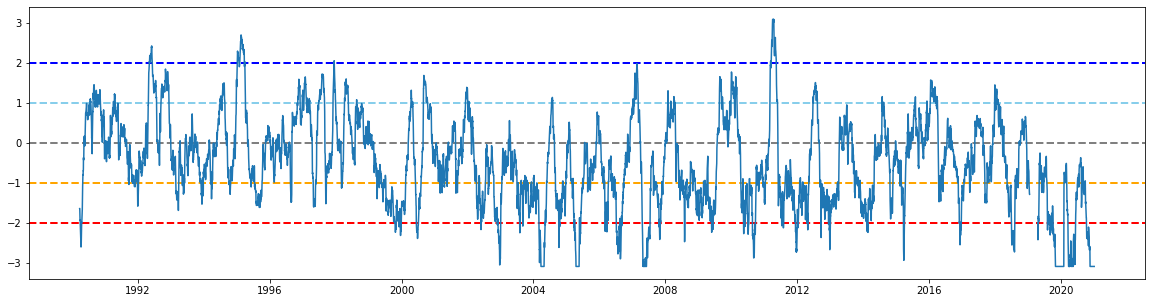

In [16]:
import matplotlib.pyplot as plt
fig=plt.subplots(figsize=(20,5))

plt.plot(ts_spi.index,test_spi,zorder=20)
plt.axhline(y=-2,linewidth=2, linestyle='dashed',color='r',label='November 2019')
plt.axhline(y=-1,linewidth=2,linestyle='dashed', color='orange',label='November 2019')
plt.axhline(y=0,linewidth=2,linestyle='dashed', color='grey',label='November 2019')
plt.axhline(y=1,linewidth=2,linestyle='dashed', color='skyblue',label='November 2019')
plt.axhline(y=2,linewidth=2,linestyle='dashed', color='blue',label='November 2019')
